<a href="https://colab.research.google.com/github/taliafabs/STA496/blob/main/Assignments/PollForecastingAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poll Forecasting

## Workplace setup and data preparation

In [144]:
# --- WORKPLACE SETUP ---

# run this line if pygam is not already installed
%pip install pygam

# data preparation
import pandas as pd
import numpy as np

# statistical libraries
import pygam as pg
import statsmodels.api as sm
from pygam import LinearGAM, s, f
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


# visualizations
import matplotlib.pyplot as plt
import seaborn

In [6]:
# helpers
def logit(p): # p is proportion
    return np.log(p) - np.log(1 - p)

def sigmoid(z): # z is the logit (sigmoid is inv logit)
    return 1 / (1 + np.exp(-z))

Data was obtained from the FiveThirtyEight github page.
Dataset selected: uncorrected 2024 presidential election polling averages (from before RFK Jr. withdrew).
I decided to still use this dataset because my focus is on the margin between Trump and Biden and there is limited high-quality data available.

In [4]:
url = "https://raw.githubusercontent.com/fivethirtyeight/data/4c1ff5e3aef1816ae04af63218015066e186c147/polls/2024-averages/presidential_general_averages_2024-09-12_uncorrected.csv"
raw_df = pd.read_csv(url)

In [41]:
filtered_df = raw_df[(raw_df['date'] > '2023-11-04') & (raw_df['date'] <= '2024-07-21')]
national_df = filtered_df[(filtered_df['state'] == 'National') & ((filtered_df['candidate'] == 'Trump')|(filtered_df['candidate'] == 'Biden'))] # national and only trump & biden
trump_df = national_df[national_df['candidate'] == 'Trump']
biden_df = national_df[national_df['candidate'] == 'Biden']
trump_df = trump_df[['date', 'pct_estimate']]
biden_df = biden_df[['date', 'pct_estimate']]
trump_df = trump_df.rename(columns={'pct_estimate': 'trump_pct'})
biden_df = biden_df.rename(columns={'pct_estimate': 'biden_pct'})
national_df = pd.merge(trump_df, biden_df, on='date')
national_df['date'] = pd.to_datetime(national_df['date'])
national_df['trump_margin'] = national_df['trump_pct'] - national_df['biden_pct']
election_date = pd.to_datetime('2024-11-05')
national_df['days_until_election'] = (election_date - national_df['date']).dt.days
national_df['trump_prop'] = national_df['trump_pct'] / 100
national_df['biden_prop'] = national_df['biden_pct'] / 100
national_df['trump_margin_prop'] = national_df['trump_margin'] / 100
national_df.head()

,date,trump_pct,biden_pct,trump_margin,days_until_election,trump_prop,biden_prop,trump_margin_prop
0,2024-07-21,43.46480,40.22535,3.23945,107,0.434648,0.402253,0.032394
1,2024-07-20,43.51600,40.29955,3.21645,108,0.435160,0.402996,0.032165
2,2024-07-19,43.46300,40.23650,3.22650,109,0.434630,0.402365,0.032265
3,2024-07-18,43.34035,40.08265,3.25770,110,0.433403,0.400827,0.032577
4,2024-07-17,42.33905,40.30155,2.03750,111,0.423391,0.403015,0.020375


## Exploratory Data Analysis

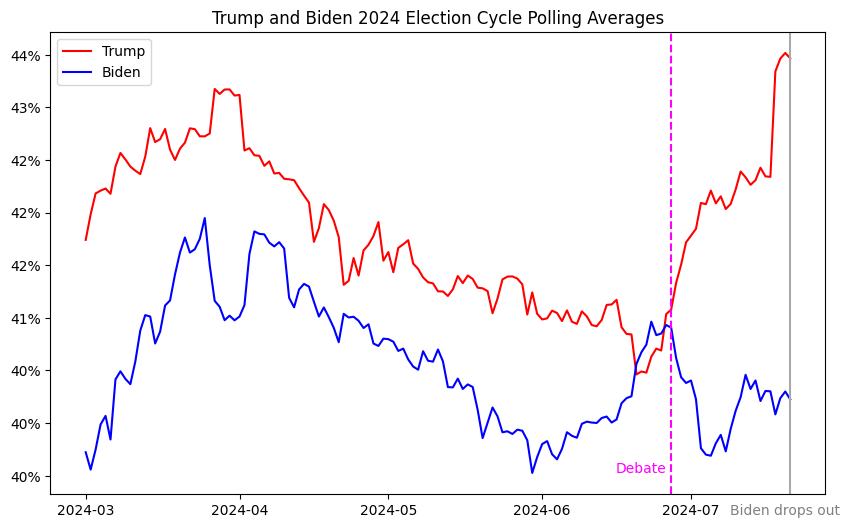

In [159]:
# trump vs biden polling
# plot the poll dates
plt.figure(figsize=(10, 6))
plt.title("Trump and Biden 2024 Election Cycle Polling Averages")
plt.plot(national_df['date'], national_df['trump_pct'], label='Trump', color='red')
plt.plot(national_df['date'], national_df['biden_pct'], label='Biden', color='blue')

# vertical line at June 27, 2024
debate_date = pd.to_datetime('2024-06-27')
plt.axvline(x=debate_date, color='magenta', linestyle='--')

plt.text(debate_date - pd.Timedelta(days=1), plt.ylim()[0] + 0.2, 'Debate',
         color='magenta', horizontalalignment='right', fontsize=10)

biden_exit = pd.to_datetime('2024-07-21')
plt.axvline(x=biden_exit, color='darkgray', linestyle='-')
plt.text(biden_exit + pd.Timedelta(days=10), plt.ylim()[0] - 0.2, 'Biden drops out',
         color='gray', horizontalalignment='right', fontsize=10)

# show % on y axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y/100)))

# legend
plt.legend()
plt.show()


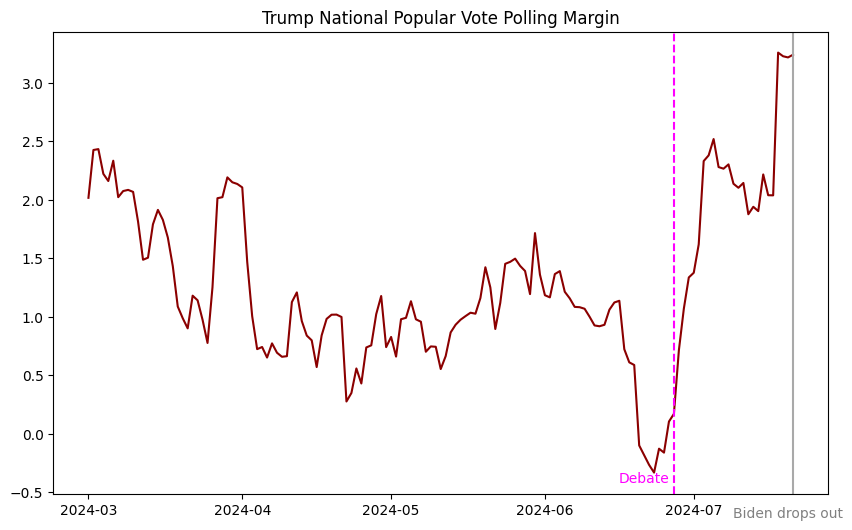

In [163]:
# trump margin
plt.figure(figsize=(10, 6))
plt.title('Trump National Popular Vote Polling Margin')
plt.plot(national_df['date'], national_df['trump_margin'], label='Trump', color='darkred')
plt.axvline(x=pd.to_datetime('2024-06-27'), color='magenta', linestyle='--')
plt.text(debate_date - pd.Timedelta(days=1), plt.ylim()[0] + 0.1, 'Debate',
         color='magenta', horizontalalignment='right', fontsize=10)
biden_exit = pd.to_datetime('2024-07-21')
plt.axvline(x=biden_exit, color='darkgray', linestyle='-')
plt.text(biden_exit + pd.Timedelta(days=10), plt.ylim()[0] - 0.2, 'Biden drops out',
         color='gray', horizontalalignment='right', fontsize=10)
plt.show()

## Generalized additive model (GAM) application

I learned about generalized additive models (GAMs) in STA303 Methods of Data Analysis II last semester. In that course, I worked with the `mgcv` package in R to fit Gaussian and non-Gaussian GAMs and Generalized Additive Mixed Models (GAMMs) to various time trends datasets in order to identify trends over time, seasonality, and produce forecasts + prediction intervals. This led me to the question of how the 2024 U.S. Presidential Election would have played out if 82-year-old former President Joe Biden continued his campaign and remained the Democratic nominee.

I had a difficult time finidng 2024 election cycle presidential polling data, so I settled with a dataset from the FiveThirtyEight GitHub; it includes Trump cabinet secretary Robert F. Kennedy Jr., who was a third-party candidate until August 2024. I treat this as a modeling exercise and an opportunity to apply what I learned about GAMs in STA303 instead of an actual academic forecast of what would have happened if Biden remained in the race. I do not have high enough quality data to do that.

I will fit GAM using the Python `pygam` and `statsmodels` packages to "estimate" Trump's popular vote margin if Biden had remained in the race. I fit and train the GAM on 2024 Presidential Election cycle polling data from July 20, 2024 (the day Biden exited the race) and earlier.

Model:
$$
\text{Y}_i \sim N(\mu_i, \sigma^2) \\
\mu_i = \beta_0 + f(\text{date}) + \epsilon_i
$$

Where:
* $Y_i$ is the margin between Trump and Biden recorded in polls on day $i$
* $\beta_0$ is the intercept.
* $f(\text{date}_i)$ is the smooth trend over time, modelled by a spline.
* $\epsilon_i \sim N(0,\sigma^2)$  are the residuals

In [89]:
# prepare a poll dataframe
poll_df = national_df[['date', 'days_until_election', 'trump_prop', 'biden_prop', 'trump_margin_prop']]

# logit transform the proportions
poll_df['trump_logit'] = np.log(poll_df['trump_prop'] / (1 - poll_df['trump_prop']))
poll_df['biden_logit'] = np.log(poll_df['biden_prop'] / (1 - poll_df['biden_prop']))
poll_df['trump_margin_logit'] = np.log(poll_df['trump_margin_prop'] / (1 - poll_df['trump_margin_prop']))

/tmp/ipython-input-1330559983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poll_df['trump_logit'] = np.log(poll_df['trump_prop'] / (1 - poll_df['trump_prop']))
/tmp/ipython-input-1330559983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poll_df['biden_logit'] = np.log(poll_df['biden_prop'] / (1 - poll_df['biden_prop']))
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [90]:
# using a Gaussian GAM to forecast Trump's margin if Biden had remained in the race
X = poll_df[['days_until_election']].values
y = poll_df['trump_margin_prop']

# fit the GAM on the observed polling data (up to 7/21/24)
gam = LinearGAM(s(0, n_splines=20)).fit(X, y)

In [50]:
# define the last day present in observed data
biden_exit = poll_df['days_until_election'].min()

# define number of days in the future to forecast (107 days)!
forecast_107_days = np.arange(biden_exit, -1, -1).reshape(-1, 1)

# forecast trump's margin if biden had remained in the race for those 107 days
forecast_trump_margin = gam(forecast_107_days)

# get prediction intervals
prediction_intervals = gam.prediction_intervals(forecast_107_days, width=0.95)

In [99]:
forecast_margin_pct = 100 * forecast_trump_margin
# prediction_intervals_pct = 100 * prediction_intervals
ci_lower = prediction_intervals[:,0] * 100
ci_upper = prediction_intervals[:,1] * 100
forecast_dates = pd.date_range(start=national_df['date'].max(), periods=len(forecast_trump_margin), freq='D')

In [164]:
prediction_intervals

array([[0.02142799, 0.03745739],
       [0.02200294, 0.03840161],
       [0.02255757, 0.03936614],
       [0.02309334, 0.04034954],
       [0.02361167, 0.04135038],
       [0.02411393, 0.04236727],
       [0.02460147, 0.04339891],
       [0.0250755 , 0.04444404],
       [0.0255372 , 0.0455015 ],
       [0.02598763, 0.04657024],
       [0.02642778, 0.04764925],
       [0.02685855, 0.04873765],
       [0.02728076, 0.0498346 ],
       [0.02769515, 0.05093937],
       [0.02810241, 0.05205128],
       [0.02850313, 0.05316972],
       [0.02889789, 0.05429413],
       [0.02928717, 0.05542402],
       [0.02967143, 0.05655893],
       [0.03005107, 0.05769845],
       [0.03042647, 0.05884221],
       [0.03079797, 0.05998988],
       [0.03116586, 0.06114115],
       [0.03153043, 0.06229575],
       [0.03189191, 0.06345343],
       [0.03225055, 0.06461396],
       [0.03260653, 0.06577714],
       [0.03296007, 0.06694277],
       [0.03331132, 0.06811068],
       [0.03366044, 0.06928073],
       [0.

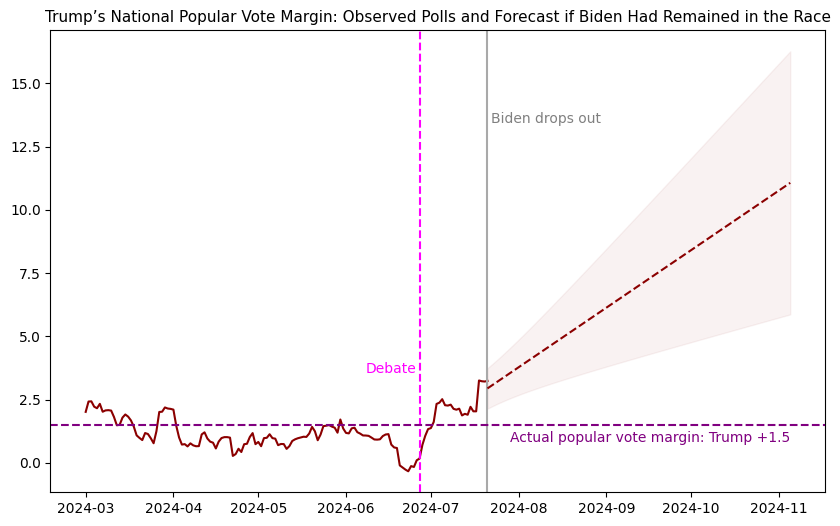

In [133]:
plt.figure(figsize=(10, 6))
# plot the observed data from before biden dropped out
plt.title('Trump’s National Popular Vote Margin: Observed Polls and Forecast if Biden Had Remained in the Race', fontsize=11)
plt.plot(national_df['date'], national_df['trump_margin'], label='Trump', color='darkred')

# debate
plt.axvline(x=pd.to_datetime('2024-06-27'), color='magenta', linestyle='--')
plt.text(debate_date - pd.Timedelta(days=1), plt.ylim()[1] + 0.1, 'Debate',
         color='magenta', horizontalalignment='right', fontsize=10)

# biden exit
biden_exit = pd.to_datetime('2024-07-21')
plt.axvline(x=biden_exit, color='darkgray', linestyle='-')
plt.text(biden_exit + pd.Timedelta(days=40), plt.ylim()[1] + 10, 'Biden drops out',
         color='gray', horizontalalignment='right', fontsize=10)

# plot the forecast
plt.plot(forecast_dates, forecast_margin_pct, label='Forecast', color='darkred', linestyle='--')
plt.fill_between(forecast_dates, ci_lower, ci_upper, color='darkred', alpha=0.05)

# horizontal line at 1.5 to show Trump's actual margin
plt.axhline(y=1.5, color='purple', linestyle='--')
plt.text(biden_exit + pd.Timedelta(days=107), plt.ylim()[0] + 2, 'Actual popular vote margin: Trump +1.5',
         color='purple', horizontalalignment='right', fontsize=10)

plt.show()

## ARIMA

Resources that I used extensively for this section include:
* Code resource: https://medium.com/@hazallgultekin/time-series-analysis-and-forecasting-with-arima-8be02ba2665a
* Math/theory resource: https://people.duke.edu/~rnau/411arim3.htm#:~:text=An%20AR(1)%20model%20is,order%20of%20differencing%20by%20one.

In [143]:
trump_margin_data = national_df[['date', 'trump_margin']]
trump_margin_data = trump_margin_data.sort_values(['date'])
trump_margin_data = trump_margin_data.set_index('date')

Start by checking whether the data is stationary or must be differenced (use d>1)
resource used: https://medium.com/@hazallgultekin/time-series-analysis-and-forecasting-with-arima-8be02ba2665a


In [145]:
# check that the data is stationary
adf_test = adfuller(trump_margin_data['trump_margin'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.969164
p-value: 0.300255


The p-value is 0.3 > 0.05; this means that the data does not meet the stationary criterion and must be differenced. An ARIMA (p, 0, q) will not work well. Need to use d > 0 non-seasonal differences.

In [156]:
# checking to see if d=1 works
data_diff1 = trump_margin_data['trump_margin'].diff().dropna()
adf_test = adfuller(data_diff1)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -10.496606
p-value: 0.000000


After differencing using d=1, the ADF test results in a p-value of $\approx 0 < 0.05$. This means that the time series is now stationary and increasing the d to 2 is not necessary.

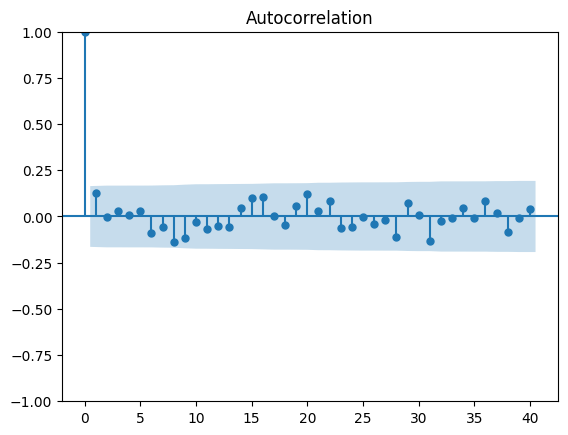

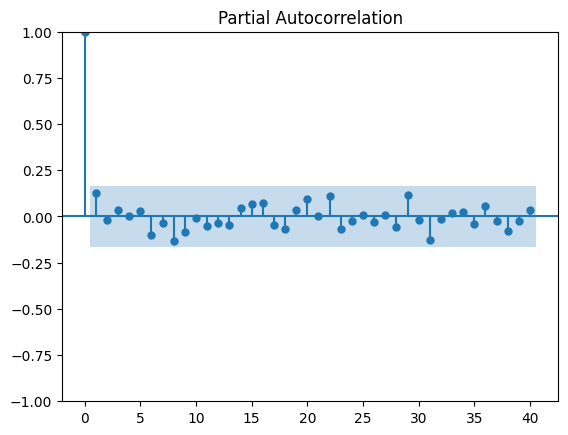

In [157]:
# plot autocorrelations
# resource used: https://medium.com/@hazallgultekin/time-series-analysis-and-forecasting-with-arima-8be02ba2665a
plot_acf(data_diff1, lags=40)

# pacf
plot_pacf(data_diff1, lags=40)

plt.show()

The PACF of the differenced series displays a sharp cutoff at the lag-1 and the lag-1 autocorrelation is positive, so an AR term of 1 (p=1) will be used. The ACF of the differenced series has a sharp cutoff at lag 1, so an MA term of 1 (q=1) will also be used.

An ARIMA(1, 1, 1) model will be used. This combines the features of **a**uto**r**egressive and **m**oving **a**verage models and has the following prediction equation:

$$Y(t) = \mu + Y(t-1) + \phi(Y(t-1) - Y(t-2)) - \theta \epsilon(t-1)$$
Resource used: https://people.duke.edu/~rnau/411arim3.htm#:~:text=An%20AR(1)%20model%20is,order%20of%20differencing%20by%20one.

In [109]:
# fit an ARIMA(1, 1, 1) model
arima_model = ARIMA(trump_margin_data, order=(1, 1, 1))
arima_fit = arima_model.fit()

In [110]:
# apply the ARIMA model to produce a forecast
arima_forecast = arima_fit.forecast(steps=107)

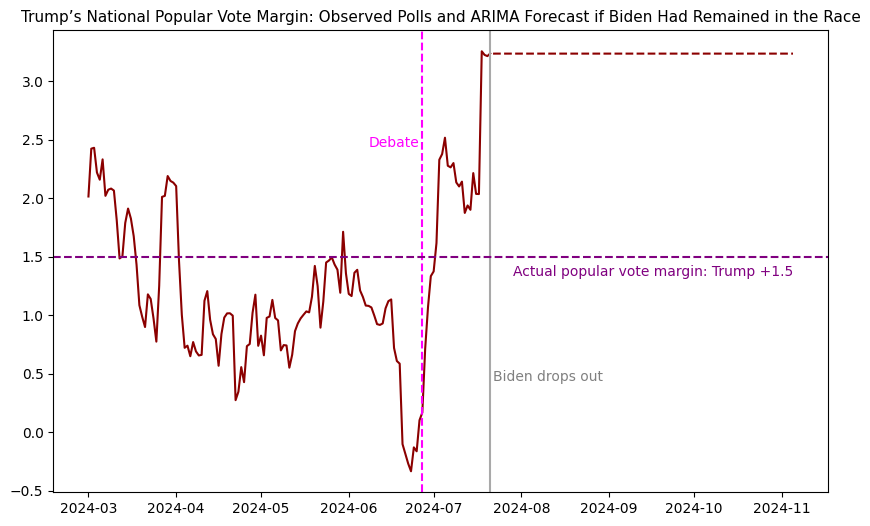

In [141]:
# plot observed data vs ARIMA forecast

plt.figure(figsize=(10, 6))

# plot observed data
plt.title('Trump’s National Popular Vote Margin: Observed Polls and ARIMA Forecast if Biden Had Remained in the Race', fontsize=11)
plt.plot(trump_margin_data.index, trump_margin_data['trump_margin'], label='Observed', color='darkred')

# ARIMA forecast
plt.plot(arima_forecast.index, arima_forecast.values, label='ARIMA Forecast', color='darkred', linestyle='--')

# debate
plt.axvline(x=pd.to_datetime('2024-06-27'), color='magenta', linestyle='--')
plt.text(debate_date - pd.Timedelta(days=1), plt.ylim()[1] + -1, 'Debate',
         color='magenta', horizontalalignment='right', fontsize=10)

# biden exit
biden_exit = pd.to_datetime('2024-07-21')
plt.axvline(x=biden_exit, color='darkgray', linestyle='-')
plt.text(biden_exit + pd.Timedelta(days=40), plt.ylim()[1] + -3, 'Biden drops out',
         color='gray', horizontalalignment='right', fontsize=10)

# horizontal line at 1.5 to show Trump's actual margin
plt.axhline(y=1.5, color='purple', linestyle='--')
plt.text(biden_exit + pd.Timedelta(days=107), plt.ylim()[0] + 1.85, 'Actual popular vote margin: Trump +1.5',
         color='purple', horizontalalignment='right', fontsize=10)
plt.show()

## Resources

*   **Generalized Additive Models (GAMs):**
    *   [Introduction to GAMs](https://www.statlearning.com/s/ISLR-Seventh-Printing.pdf) (See Chapter 7 of "An Introduction to Statistical Learning")
    *   [PyGAM documentation](https://pygam.readthedocs.io/en/latest/)
    *   [GAMs in R (mgcv package)](https://noamross.github.io/gams-in-r/)

*   **ARIMA Models:**
    *   [Hyndman's Forecasting Principles and Practice (Chapter on ARIMA)](https://otexts.com/fpp3/arima.html)
    *   [Statsmodels ARIMA documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html)

*   **Time Series Analysis in Python:**
    *   [Python for Finance (Chapter on Time Series)](https://www.oreilly.com/library/view/python-for-finance/9781491945278/)
    *   [Kaggle time series tutorials](https://www.kaggle.com/learn/time-series)